Alexander S. Lundervold, October 27th, 2019

<img width=30% src="../assets/uc.png">

# Boosting

> Producing strong learners from an ensemble of weak learners

# Setup

In [1]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from pathlib import Path # Very convenient when working with paths in Python (https://docs.python.org/3.6/library/pathlib.html)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

import seaborn as sns # For nicer plots

In [4]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

# Introduction

Now we're ready for one of the most powerful classes of machine learning models there is: based on **boosted trees**. With this tool added to you toolbelt you're well-equipped to face most machine learning modelling tasks you'll meet in real life.

We've learned that random forests are ensembles of decision trees, making predictions by simply averaging all the models in the ensemble. **Boosting** takes another approach to ensembling: new members are added to the ensemble _sequentially_, each new model is trained on the _errors_ of the ensemble constructed so far, iteratively learning from its mistakes. We'll focus on boosting based on decision trees, as these are the most common base-models.

One of the main boosting techniques is **AdaBoost**. Here each additional tree focuses on the examples (i.e. _instances_) that were misclassified by the previous trees. 

In **gradient boosting**, each tree added to the ensemble tries to predict the *residual error* from the previously added tree. In other words, it's trained to predict the difference between the correct value and the value predicted from the ensemble so far. 

Each individual tree is what's called a **weak learner**, not able to fit the data very well. But by combining them by having each tree try to predict the residual of the previous trees' predictions, the result is a very **strong learner**. In fact, we can end up with some of the strongest learnes we know. 

See Geron's notebook here: https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb

More details about gradient boosting can be found [here](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/) or [here]() (we will base our discussion partly on the one in the first link).

# AdaBoost: Adaptive boosting

AdaBoost was introduced in 1995 ([here](https://www.sciencedirect.com/science/article/pii/S002200009791504X)) and was the first boosting algorithm that had practical use cases. It won the authors the 2003 Gödel Prize for outstanding journal article in theoretical computer science because of the algorithm's _"elegance, simplicity of implementation, its wide applicability, and its striking success in reducing errors in benchmark applications even while its theoretical assumptions are not known to hold"_. 

AdaBoost _"set off an explosion of research in the fields of statistics, artificial intelligence, experimental machine learning, and data mining"_ ([source](http://eatcs.org/index.php/component/content/article/505)).

The basic idea is relatively simple: 

- Give each instance in the training data an _instance weight_, initally set to 1/m where m is the number of instances.
- Extract a sample of the training data and train a *weak learner* on it. The weak learners in AdaBoost are typically decision trees of depth 1 (so-called *decision stumps*), but other models can be used. 
- Calculate a weight for the learner, based on its error rate. Higher accuracy means higher weight.
- Then increase the weight of the misclassified instances according to the learner's weight. An instance misclassified by a high-weight learner gets higher weight than one misclassified by a low weight learner.
- Extract another sample from the training data, sampled according to the instance weights. 
- Train the next weak learner on the sampled data, compute the learner weight and update the weights of the training instances accordingly. 
- Continue until perfect fit or `n_estimators` have been trained. 

Each new learner added to the ensemble corrects the shortcomings of previous models as it focuses on high-weight instances. In other words, the weighing of the training data makes the new learner focus more on difficult cases.

Predictions from AdaBoost are made by producing predictions from all the weak learners, weighted according to their weights.

<img width=50% src="assets/adaboost.png">

### AdaBoost in more detail

To make the above procedure a bit clearer, here are the steps for classificatio using AdaBoost in more detail:

At the start we don't know which instances are most difficult so we give them the same weight, making sure that the sum of all weights is 1: set the weights of all $m$ instances to $w^{(i)} = 1/m$ (note that the sum of all instance weights is 1).

1. Train a weak learner on a sample of the training data
2. Get the error rate of the learner on the sample:

$$r_i = \frac{\mbox{sum of weights of errors}}{\mbox{sum of errors}} = \frac{\underset{\hat{y}_j^{(i)} \neq y_j}{\sum w^{(i)}}}{\sum w^{(i)}}$$

3. Compute the learner's weight:

$$\alpha_j = \eta \log \frac{1-r_j}{r_j},$$ where $\eta$ is the learning rate. (See below for an explanation of the formula.)

4. Update all the weights of the misclassified instances:

$$\mbox{For  } \hat{y}_j^{(i)} \neq y^{(i)}: \quad w^{(i)} := w^{(i)} \exp(\alpha_j),$$

and normalize them to keep the sum equal to 1: $$w^{(i)} := \frac{w^{(i)}}{\sum w^{(i)}}.$$

Repeat 1-4.

##### **A closer look at the learner weights:**

In [5]:
# The error rate of a learner is between 0 and 1
r = np.arange(0.001, 1, 0.01) 

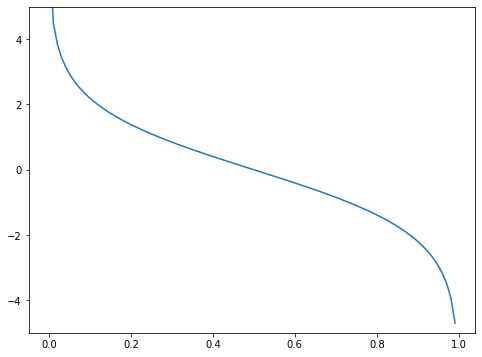

In [6]:
# The formula for the learner weights
learning_rate = 1

plt.figure(figsize=(8,6))
plt.plot(r, learning_rate*np.log((1-r)/r))
plt.ylim([-5,5])
plt.show()

> Higher error rate means lower learner weight.

### In scikit-learn

Let's try it out on the California Housing data provided by scikit-learn:

In [7]:
from sklearn.datasets import fetch_california_housing

In [8]:
housing = fetch_california_housing(data_home='./part4data')

In [9]:
df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
y = housing.target

In [10]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

Let's first try a single decision stump (our weak learner):

In [15]:
dt_reg = DecisionTreeRegressor(max_depth=1, random_state=42)
dt_reg.fit(X_train, y_train)
mean_squared_error(y_test, dt_reg.predict(X_test))

0.9358890477080715

..then an AdaBoost ensemble of 10 decision stumps:

In [16]:
ada_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1), 
                             n_estimators=10, random_state=42)

In [17]:
ada_reg.fit(X_train, y_train)
mean_squared_error(y_test, ada_reg.predict(X_test))

0.8355015981506355

# Gradient boosting: gradient descent + boosting

In AdaBoost the learners added to the ensemble tries to correct its predecessors by changing the weights on the data points. Gradient boosting has the same objective, but rather than tweaking the instance weights, each new learner attempts to predict the _residual error_ of the ensemble.

## Residual errors: the basic idea behind gradient boosting

We'll try to build such a boosting ensemble ourselves. First we'll explain it in a spreadsheet, then in code. Gradient boosting builds on this, as we shall see.

### Residual errors and boosting using a spreadsheet

> Go to http://bit.ly/boosting_example for boosting explained in a spreadsheet. We'll go through it in the lecture.

### Residual errors and boosting using scikit-learn

Let's use the randomly generated data as in the textbook (see Chapter 7).

In [18]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

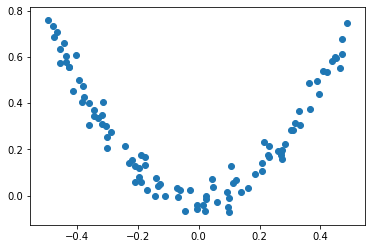

In [19]:
plt.scatter(X,y)
plt.show()

We also need some new data on which to make predictions:

In [20]:
X_new = np.linspace(-0.5, 0.5, 500)
X_new = X_new.reshape(-1, 1)

Our initial model will be the mean value of the target (as that is the value minimizing mean squared error):

In [21]:
from sklearn.dummy import DummyRegressor

In [22]:
F_0 = DummyRegressor(strategy='mean')

In [23]:
F_0.fit(X, y)

DummyRegressor(constant=None, quantile=None, strategy='mean')

This is our initial model and our goal is to improve it.

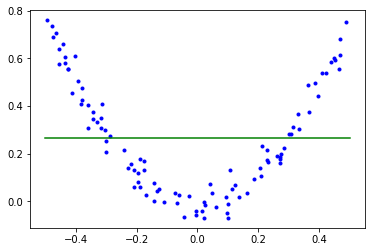

In [24]:
fig, ax = plt.subplots()
ax.plot(X[:, 0], y, 'b.')
ax.plot(X_new, F_0.predict(X_new), 'g-')
plt.show()

Next we'll train a single decision tree on the residuals of the initial model:

In [25]:
y_0 = y - F_0.predict(X)

In [26]:
from sklearn.tree import DecisionTreeRegressor
h_0 = DecisionTreeRegressor(max_depth=2)
h_0.fit(X,y_0)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Our first ensemble is now simply the sum of $F_0$ and $h_0$: $$F_1 = F_0 + h_0$$

We take a look at its predictions on some new data:

In [27]:
# A convenience function for plotting predictions of our ensembles
def plot_predictions(models):
    y_pred = sum(model.predict(X_new) for model in models)
    fig, ax = plt.subplots()
    ax.plot(X[:, 0], y, 'b.')
    ax.plot(X_new, y_pred, 'g-')
    plt.show()

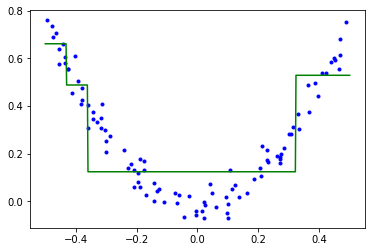

In [28]:
plot_predictions([F_0, h_0])

A big improvement!

Let's make a larger ensemble:

In [29]:
# Residuals from previous ensemble
F_1_pred = F_0.predict(X) + h_0.predict(X) 
y1 = y - F_1_pred

In [30]:
# Model fitted to the residuals:
h_1 = DecisionTreeRegressor(max_depth=2)
h_1.fit(X,y1)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [31]:
# Updated ensemble:
F_2_pred = F_1_pred + h_1.predict(X)

In [32]:
# Residuals:
y2 = y - F_2_pred

In [33]:
# Model fitted to the residuals:
h_2 = DecisionTreeRegressor(max_depth=2)
h_2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [34]:
# Updated ensemble:
F_3_pred = F_2_pred + h_2.predict(X)

Here are the initial ensemble results:

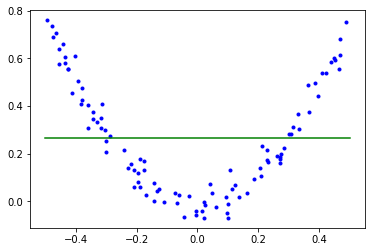

In [35]:
plot_predictions([F_0,])

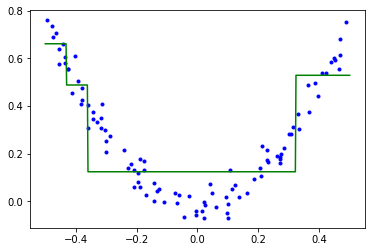

In [36]:
plot_predictions([F_0, h_0])

After adding a second model:

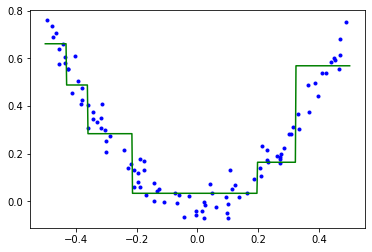

In [37]:
plot_predictions([F_0, h_0, h_1])

After adding another model:

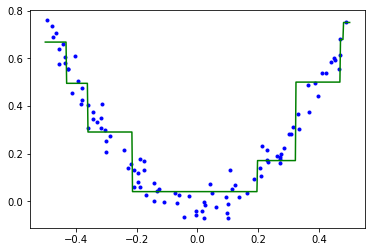

In [38]:
plot_predictions([F_0, h_0, h_1, h_2])

**Magic!**

We can continue this for as long as we want:

In [39]:
def boosting(k=3, X=X, y=y):
    """
    Trains k trees on the randomly generated points
    """

    # Construct models
    models = []
    
    ## Initial model:
    F_0 = DummyRegressor(strategy='mean')
    F_0.fit(X,y)
    y = y - F_0.predict(X)
    models.append(F_0)
    
    ## Creating the ensemble
    for i in range(k):
        h = DecisionTreeRegressor(max_depth=2)
        h.fit(X,y)
        models.append(h)
        y = y - h.predict(X)
    
    plot_predictions(models)

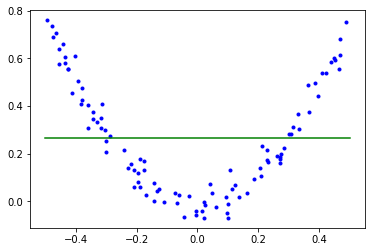

In [40]:
boosting(k=0)

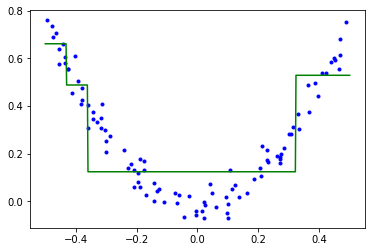

In [41]:
boosting(k=1)

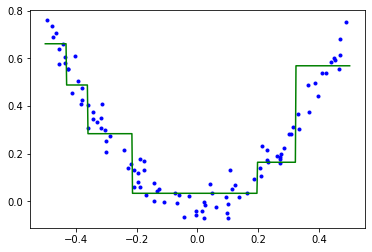

In [42]:
boosting(k=2)

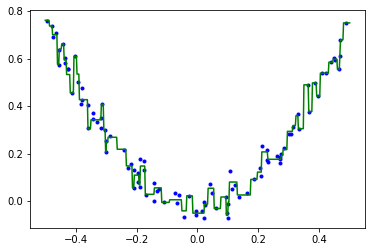

In [43]:
boosting(k=30)

### Residual errors and the boosting algorithm:

The above recursive procedure can be described as follows:

* Create an initial model, $F_0$
* Fit a model to the residuals, $h_0(x) \sim y - F_0(x)$
* Create an ensemble, $F_1(x) = F_0(x) + h_0(x)$
* Fit a model to the residuals, $h_1(x) \sim y - F_1(x)$
* Create an ensemble, $F_2(x) = F_1(x) + h_1(x)$
* ... continue until reaching a stopping criterion

## Where's the gradient in gradient boosting?

It turns out that mathematically, the above procedure is actually doing gradient descent using the mean squared error loss function. 

> Take a look back at Part 3 of the course if your knowledge of gradient descent and the mean squared error function is a bit rusty.

The mean squared error loss function is

$$L(y, \hat{y}) = \frac 1m \sum_{i=1}^m (y_i - \hat{y}_i)^2.$$

Its partial derivatives with respect to the $\hat{y}_j$ are 

\begin{align}
\frac{\partial}{\partial \hat{y}_j} L(y,\hat{y}) &= \frac1m \frac{\partial}{\partial \hat{y}_j} (y_j - \hat{y}_j) \\ 
&= -\frac2m(y_j - \hat{y}_j)
\end{align}

The gradient is therefore

$$\nabla_{\hat{y}} L(y,\hat{y}) = -\frac2m (y - \hat{y})$$

When we're doing $F_m(x) = F_{m-1}(x) + h_m(x)$ where $h_m(x)$ is a model fitted to the residuals $y-\hat{y}$ of the previous model, we're actually doing a gradient descent on the mean squared error loss function!

More precisely, when we're adding a new model to the ensemble, we're adding the negative of the gradient of the mean squared error loss function, up to a constant (called the learning rate in both gradient descent and in gradient boosting).

This view of things provides the fundamental insight behind gradient boosting: we can swap out the mean squared loss function with any other (differentiable) loss function $L(y, \hat{y})$!

See [here](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/) for further details.

## Gradient boosting in scikit-learn

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

In [45]:
#??GradientBoostingRegressor

Let's try it on the housing data:

In [46]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, 
                                 learning_rate=1.0)

In [47]:
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [48]:
mean_squared_error(y_test, gbrt.predict(X_test))

0.5636337101732388

# Other advanced boosting techniques and libraries worth knowing about

There are multiple libraries for gradient boosting that can provide significantly more powerful models than scikit-learn. Two extremely widely used ones (you've surely come across them on Kaggle) are 

- XGBoost: A widely used implementation of gradient boosting. Here are some sources for information: https://xgboost.readthedocs.io/en/latest, https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost, https://campus.datacamp.com/courses/extreme-gradient-boosting-with-xgboost/classification-with-xgboost
- LightGBM: Another often-used gradient boosting library (in fact it's recently become more popular than XGBoost on Kaggle). Have a look at the documentation here: https://lightgbm.readthedocs.io/en/latest/index.html

If you want to use **stacking** where multiple model predictions are combined by training a *blender* (instead of simply voting), take a look at ML-Ensemble https://github.com/flennerhag/mlens and vecstack https://github.com/vecxoz/vecstack.

<img width=30% src="assets/stack.png">

What if it was possible to automatically select the models to use _dynamically at test time_? I.e. for a given data point, to only use the classifiers that are most likely to perform best on that exact data point? This is called **dynamic ensemble selection** or **dynamic classifier selection**, and is available in a nice scikit-learn package DESlib: https://github.com/scikit-learn-contrib/DESlib, https://deslib.readthedocs.io/en/latest/. 

# What's next?

Now you know about some of the most widely used and powerful models in machine learning, and we've gone into details about how most of them are are constructed, trained and used: logistic regression, decision trees, random forests, gradient boosted trees, and you've seen the gradient boosting libraries XGBoost and LightGBM. 

You've seen how several models can be combined in ensembles, often increasing performance. 

You've learned about techniques from regularization that plays an important part in ensuring good model performance, measured using a variety of performance measures.

Further, you've seen the importance of feature engineering, and we've picked up some of the most common tools for understanding and preparing data in a machine learning context. 

One thing we haven't spent much time on is how to find good settings for the paramaters of our models that are not tuned during training. E.g. the `n_estimators` and `max_depth` of tree-based models. For some models such parameters have a huge impact on performance, and can turn a mediocre model into a high-performance super model! We turn to this next: techniques for **hyperparameter optimization**.